In [326]:
#import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_percentage_error
import xgboost as xgb
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.layers import Flatten
from sklearn.preprocessing import StandardScaler
from datetime import datetime, timedelta
import matplotlib.dates as mdates

## Preliminary analysis:


In [76]:
#Importing the datasets into the Python environment
sales = pd.read_csv('sales.csv')
restaurants = pd.read_csv('resturants.csv')
items = pd.read_csv('items.csv')

In [77]:
# Examining the shape and structure of each dataset
print("Sales Data Shape:", sales.shape)
print("Sales Data Preview:\n", sales.head())
print('')
print("Sales Data Information:", sales.info())
print('')


print("Restaurants Data Shape:", restaurants.shape)
print("Restaurants Data Preview:\n", restaurants.head())
print("Restaurants Data Information:", restaurants.info())
print('')
print('')

print("Items Data Shape:", items.shape)
print("Items Data Preview:\n", items.head())
print("Items Data Information:", items.info())

Sales Data Shape: (109600, 4)
Sales Data Preview:
          date  item_id  item_count   price
0  01-01-2019        3           2   58.44
1  01-01-2019        4          22  581.24
2  01-01-2019       12           7   34.09
3  01-01-2019       13          12   50.16
4  01-01-2019       16         136  436.56

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 109600 entries, 0 to 109599
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   date        109600 non-null  object 
 1   item_id     109600 non-null  int64  
 2   item_count  109600 non-null  int64  
 3   price       109600 non-null  float64
dtypes: float64(1), int64(2), object(1)
memory usage: 3.3+ MB
Sales Data Information: None

Restaurants Data Shape: (6, 2)
Restaurants Data Preview:
    id            name
0   1     Bob's Diner
1   2  Beachfront Bar
2   3     Sweet Shack
3   4        Fou Cher
4   5     Corner Cafe
<class 'pandas.core.frame.DataFrame'>
RangeInd

In [78]:
# Checking for missing values and outliers
print("Missing values in Restaurants Dataset:")
print(restaurants.isnull().sum())

print("Missing values in Sales Dataset:")
print(sales.isnull().sum())

print("Missing values in Items Dataset:")
print(items.isnull().sum())

Missing values in Restaurants Dataset:
id      0
name    0
dtype: int64
Missing values in Sales Dataset:
date          0
item_id       0
item_count    0
price         0
dtype: int64
Missing values in Items Dataset:
id          0
store_id    0
name        0
kcal        0
cost        0
dtype: int64


In [79]:
# Basic statistics for outlier detection
print("\nItems description:")
print(items.describe())
print("\nSales description:")
print(sales.describe())


Items description:
               id    store_id         kcal        cost
count  100.000000  100.000000   100.000000  100.000000
mean    50.500000    3.520000   536.730000   11.763700
std     29.011492    1.708446   202.212852    8.991254
min      1.000000    1.000000    78.000000    1.390000
25%     25.750000    2.000000   406.250000    5.280000
50%     50.500000    4.000000   572.500000    7.625000
75%     75.250000    5.000000   638.250000   18.790000
max    100.000000    6.000000  1023.000000   53.980000

Sales description:
             item_id     item_count          price
count  109600.000000  109600.000000  109600.000000
mean       50.500000       6.339297      58.428271
std        28.866202      30.003728     214.812200
min         1.000000       0.000000       0.000000
25%        25.750000       0.000000       0.000000
50%        50.500000       0.000000       0.000000
75%        75.250000       0.000000       0.000000
max       100.000000     570.000000    2224.800000


### Significance of Outliers in item_count

Outliers in the `item_count` column (total count of items sold per day) can be significant because they might indicate:

- **Genuine High Demand Days**: Special events, promotions, holidays, or weekends where sales spike naturally.
- **Data Entry Errors**: Mistakenly recorded values due to human or system errors.
- **Bulk Orders**: Large customers placing bulk orders for catering or special occasions.
- **Stock Clearance or Discounts**: Sudden price drops or discounts leading to a surge in purchases.


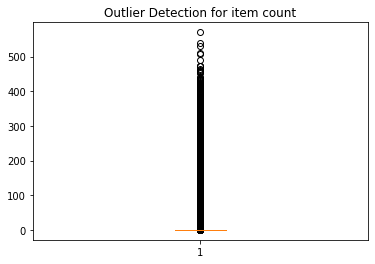

In [11]:
# Outlier detection
plt.boxplot(sales['item_count'])
plt.title('Outlier Detection for item count')
plt.show()

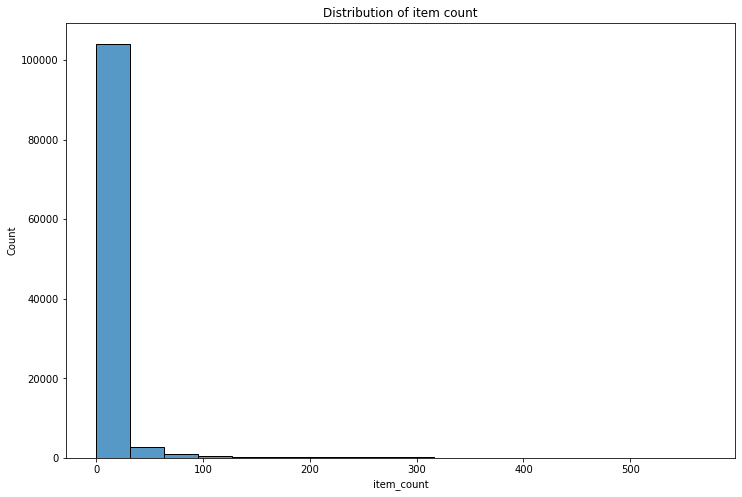

In [13]:
# distribution of item count
plt.figure(figsize=(12,8))
sns.histplot(sales['item_count'])
plt.title('Distribution of item count')
plt.show()

If the outliers are due to data entry errors, they can skew model performance and should be corrected or removed. if they represent real business trends, keeping them can improve forecasting accuracy.

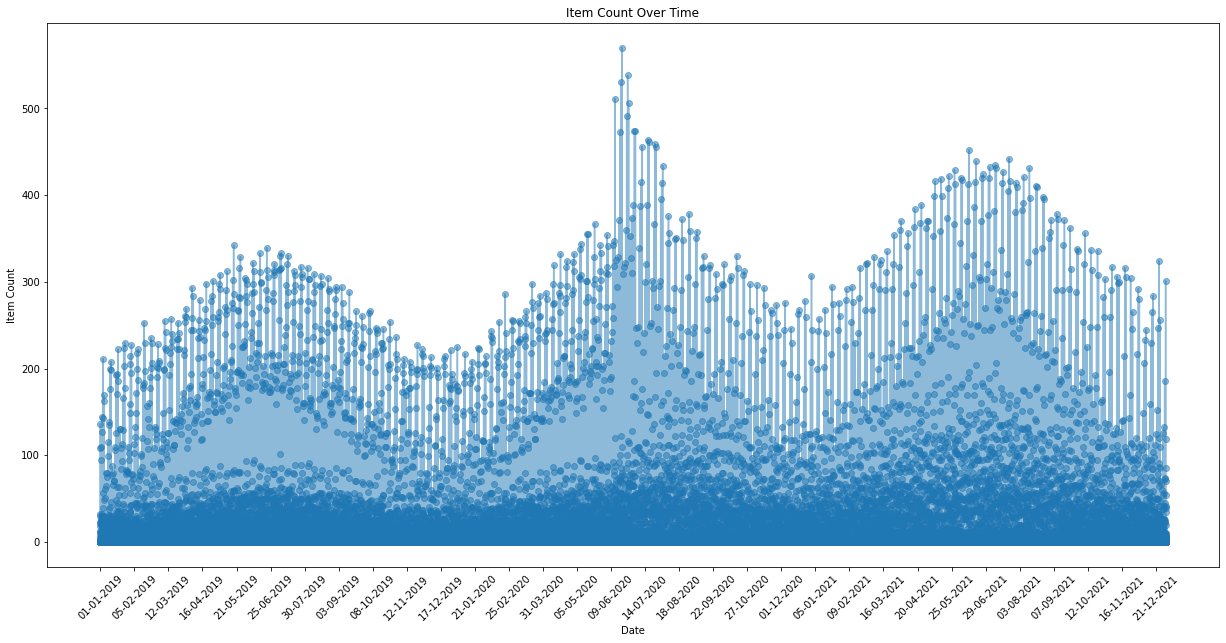

In [63]:
# Line plot of item_count over time
plt.figure(figsize=(21,10))
plt.plot(sales['date'], sales['item_count'], marker='o', linestyle='-', alpha=0.5)
plt.title("Item Count Over Time")
plt.xlabel("Date")
plt.ylabel("Item Count")
plt.xticks(sales['date'][::3500], rotation=45)
plt.show()

The data shows repeated peaks and troughs, indicating a seasonal trend. This suggests the outliers might be real business phenomena rather than errors. So we won't be removing the outliers.

In [80]:
# Merging sales with items on item_id
merged_data = pd.merge(sales, items, left_on='item_id', right_on='id', how='left')

# Merging with restaurants on store_id
merged_data = pd.merge(merged_data, restaurants, left_on='store_id', right_on='id', how='left')

In [81]:
display(merged_data)

,date,item_id,item_count,price,id_x,store_id,name_x,kcal,cost,id_y,name_y
0,01-01-2019,3,2,58.44,3,1,Sweet Fruity Cake,931,29.22,1,Bob's Diner
1,01-01-2019,4,22,581.24,4,1,Amazing Steak Dinner with Rolls,763,26.42,1,Bob's Diner
2,01-01-2019,12,7,34.09,12,1,Fantastic Sweet Cola,478,4.87,1,Bob's Diner
3,01-01-2019,13,12,50.16,13,1,Sweet Frozen Soft Drink,490,4.18,1,Bob's Diner
4,01-01-2019,16,136,436.56,16,1,Frozen Milky Smoothy,284,3.21,1,Bob's Diner
...,...,...,...,...,...,...,...,...,...,...,...
109595,31-12-2021,96,0,0.00,96,5,Blue Ribbon Fish with Bread Lunch,708,21.93,5,Corner Cafe
109596,31-12-2021,97,0,0.00,97,4,Original Fruity Cod with Bread and Vegetables ...,744,28.65,4,Fou Cher
109597,31-12-2021,98,0,0.00,98,2,Original Sweet Milky Soft Drink,579,5.00,2,Beachfront Bar
109598,31-12-2021,99,0,0.00,99,4,Frozen Tomato Soft Drink,423,5.32,4,Fou Cher


In [82]:
# Drop the unnecessary columns
merged_data.drop(columns=['id_x', 'id_y'], inplace=True)

# Rename the columns
merged_data.rename(columns={'name_x': 'item_name', 'name_y': 'store_name'}, inplace=True)

In [83]:
display(merged_data)

,date,item_id,item_count,price,store_id,item_name,kcal,cost,store_name
0,01-01-2019,3,2,58.44,1,Sweet Fruity Cake,931,29.22,Bob's Diner
1,01-01-2019,4,22,581.24,1,Amazing Steak Dinner with Rolls,763,26.42,Bob's Diner
2,01-01-2019,12,7,34.09,1,Fantastic Sweet Cola,478,4.87,Bob's Diner
3,01-01-2019,13,12,50.16,1,Sweet Frozen Soft Drink,490,4.18,Bob's Diner
4,01-01-2019,16,136,436.56,1,Frozen Milky Smoothy,284,3.21,Bob's Diner
...,...,...,...,...,...,...,...,...,...
109595,31-12-2021,96,0,0.00,5,Blue Ribbon Fish with Bread Lunch,708,21.93,Corner Cafe
109596,31-12-2021,97,0,0.00,4,Original Fruity Cod with Bread and Vegetables ...,744,28.65,Fou Cher
109597,31-12-2021,98,0,0.00,2,Original Sweet Milky Soft Drink,579,5.00,Beachfront Bar
109598,31-12-2021,99,0,0.00,4,Frozen Tomato Soft Drink,423,5.32,Fou Cher


## Exploratory data analysis:

In [96]:
# Create a copy of the DataFrame
eda_dataset = merged_data.copy()

In [97]:
eda_dataset['date'] = pd.to_datetime(eda_dataset['date'], format='%d-%m-%Y')

# 2. Extract date components
eda_dataset['year'] = eda_dataset['date'].dt.year
eda_dataset['month'] = eda_dataset['date'].dt.month_name()
eda_dataset['day_of_week'] = eda_dataset['date'].dt.day_name()  # Name of the day (e.g., Monday)
eda_dataset['quarter'] = eda_dataset['date'].dt.quarter
eda_dataset['day_of_month'] = eda_dataset['date'].dt.day

a. Examine the overall date-wise sales to understand the pattern

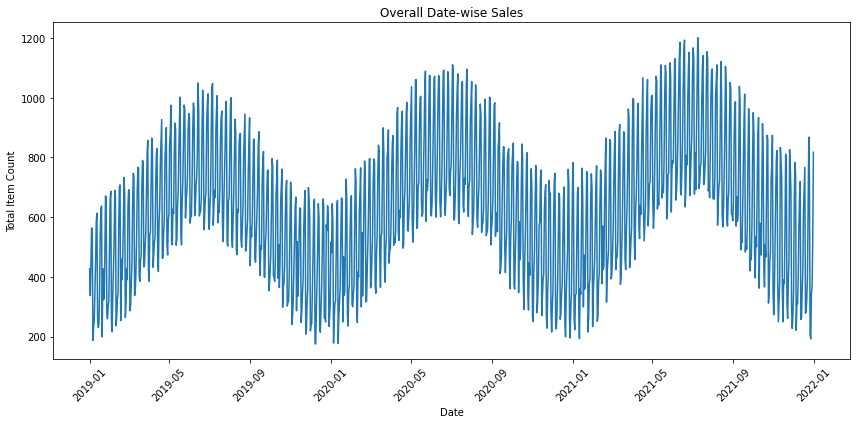

In [98]:
date_wise_sales = eda_dataset.groupby('date')['item_count'].sum()
plt.figure(figsize=(12, 6))
plt.plot(date_wise_sales.index, date_wise_sales.values)
plt.title('Overall Date-wise Sales')
plt.xlabel('Date')
plt.ylabel('Total Item Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

Here we use item_count since it reflects how many of each item were sold on a given day. This directly represents the volume of sales, which is a key indicator of demand.

b. Find out how sales fluctuate across different days of the week

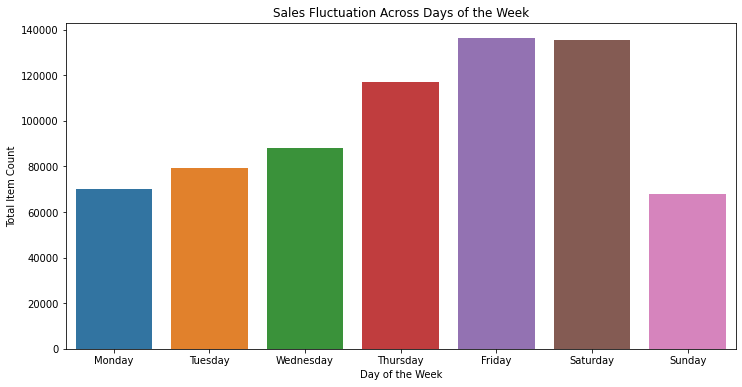

In [99]:
day_of_week_sales = eda_dataset.groupby('day_of_week')['item_count'].sum().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.figure(figsize=(12, 6))
sns.barplot(x=day_of_week_sales.index, y=day_of_week_sales.values)
plt.title('Sales Fluctuation Across Days of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Total Item Count')
plt.show()

c. Look for any noticeable trends in the sales data for different months of the year

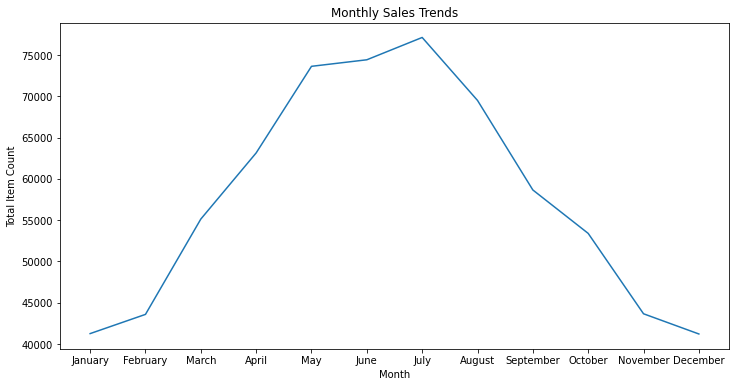

In [100]:
monthly_sales = eda_dataset.groupby('month')['item_count'].sum().reindex(
    ['January', 'February', 'March', 'April', 'May', 'June', 'July',
    'August', 'September', 'October', 'November', 'December'])
plt.figure(figsize=(12, 6))
sns.lineplot(x=monthly_sales.index, y=monthly_sales.values)
plt.title('Monthly Sales Trends')
plt.xlabel('Month')
plt.ylabel('Total Item Count')
plt.show()

d. Examine the sales distribution across different quarters averaged over the years. Identify any noticeable patterns.

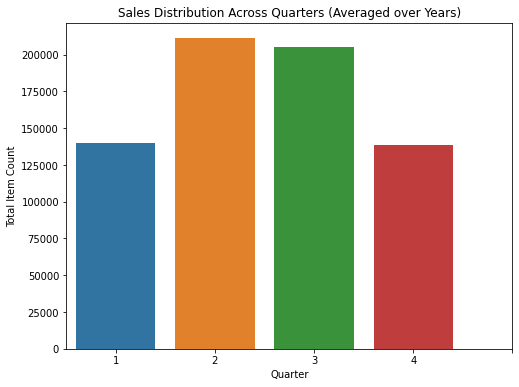

In [104]:
quarterly_sales = eda_dataset.groupby('quarter')['item_count'].sum()
plt.figure(figsize=(8, 6))
sns.barplot(x=quarterly_sales.index, y=quarterly_sales.values)
plt.title('Sales Distribution Across Quarters (Averaged over Years)')
plt.xlabel('Quarter')
plt.ylabel('Total Item Count')
plt.xticks(range(0, 5))
plt.show()

e. Compare the performances of the different restaurants. Find out which restaurant had the most
sales and look at the sales for each restaurant across different years, months, and days.

In [105]:
# e. Compare the performances of the different restaurants.
# Find out which restaurant had the most sales and look at the sales for each restaurant across different years, months, and days.

# Calculate total sales for each restaurant
restaurant_sales = eda_dataset.groupby('store_name')['item_count'].sum().sort_values(ascending=False)
print("Total Sales by Restaurant:\n", restaurant_sales)

Total Sales by Restaurant:
 store_name
Bob's Diner       687527
Surfs Up            1803
Sweet Shack         1736
Corner Cafe         1310
Beachfront Bar      1305
Fou Cher            1106
Name: item_count, dtype: int64


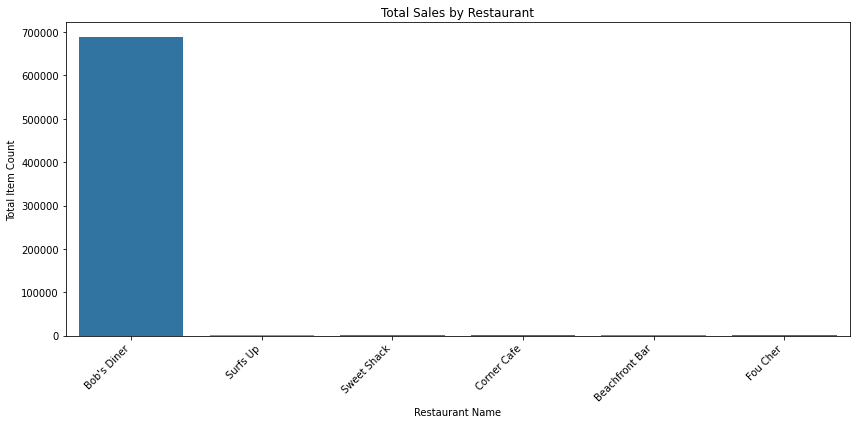

In [110]:
# Bar plot of total sales by restaurant
plt.figure(figsize=(12, 6))
sns.barplot(x=restaurant_sales.index, y=restaurant_sales.values)
plt.title('Total Sales by Restaurant')
plt.xlabel('Restaurant Name')
plt.ylabel('Total Item Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
plt.tight_layout()
plt.show()

In [106]:
# Identify the restaurant with the most sales
most_sales_restaurant = restaurant_sales.index[0]
print("\nRestaurant with the Most Sales:", most_sales_restaurant)


Restaurant with the Most Sales: Bob's Diner


In [107]:
# Sales for each restaurant across different years
restaurant_sales_by_year = eda_dataset.groupby(['store_name', 'year'])['item_count'].sum()
print("\nSales by Restaurant and Year:\n", restaurant_sales_by_year)


Sales by Restaurant and Year:
 store_name      year
Beachfront Bar  2019       439
                2020       437
                2021       429
Bob's Diner     2019    211799
                2020    230191
                2021    245537
Corner Cafe     2019       423
                2020       415
                2021       472
Fou Cher        2019       392
                2020       357
                2021       357
Surfs Up        2019       594
                2020       627
                2021       582
Sweet Shack     2019       590
                2020       554
                2021       592
Name: item_count, dtype: int64


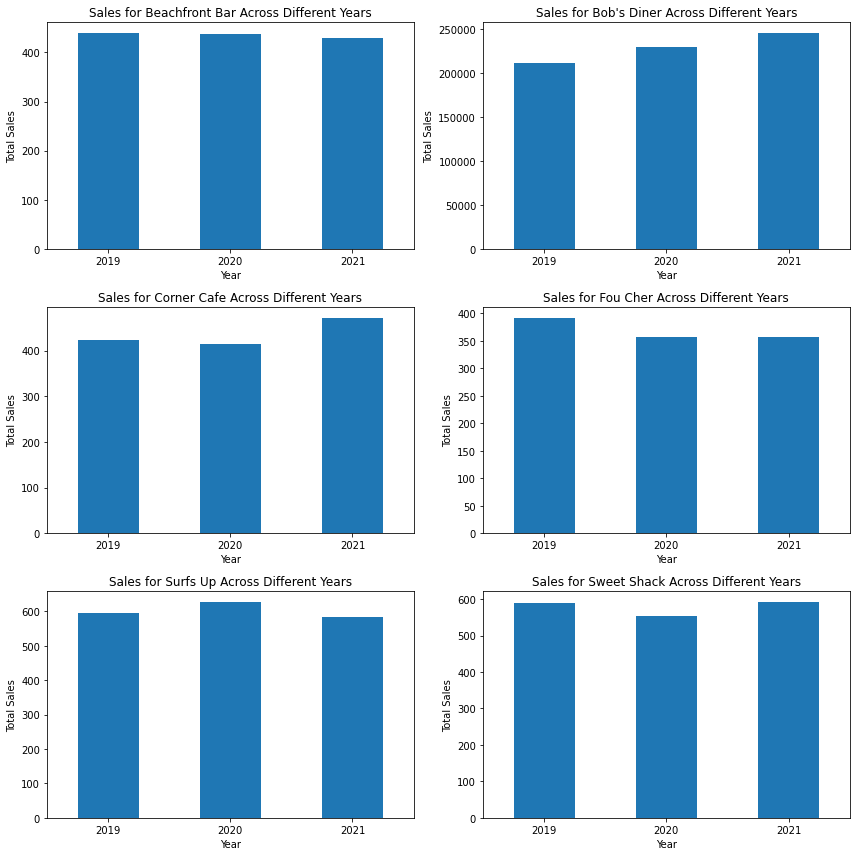

In [114]:
# Sales for each restaurant across different years

restaurant_sales_year = eda_dataset.groupby(['store_name', 'year'])['item_count'].sum().unstack()

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(12, 12))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each restaurant's sales in a subplot
for i, restaurant in enumerate(restaurant_sales_year.index):
    restaurant_sales_year.loc[[restaurant]].T.plot(
        kind='bar', ax=axes[i], legend=False
    )
    axes[i].set_title(f'Sales for {restaurant} Across Different Years')
    axes[i].set_xlabel('Year')
    axes[i].set_ylabel('Total Sales')
    axes[i].tick_params(axis='x', rotation=0)  # Keep x-ticks readable

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [133]:
# Define the correct order of months
month_order = [
    "January", "February", "March", "April", "May", "June",
    "July", "August", "September", "October", "November", "December"
]

# Group by store_name and month, then reorder the columns
restaurant_sales_by_month = (
    eda_dataset.groupby(['store_name', 'month'])['item_count'].sum()
    .unstack()
    .reindex(columns=month_order, fill_value=0)  # Ensures correct order and fills missing months
)

print("\nSales by Restaurant and Month:\n", restaurant_sales_by_month)



Sales by Restaurant and Month:
 month           January  February  March  April    May   June   July  August  \
store_name                                                                     
Beachfront Bar      107       109    117    109    113     98    103      99   
Bob's Diner       40672     43006  54510  62565  72988  73836  76528   68918   
Corner Cafe          82       111    109    103    107    119    111     113   
Fou Cher            109        72     96     92    110     84     81      78   
Surfs Up            132       170    155    146    156    138    161     162   
Sweet Shack         168       128    150    130    158    148    141     132   

month           September  October  November  December  
store_name                                              
Beachfront Bar        106      101       108       135  
Bob's Diner         58064    52772     43085     40583  
Corner Cafe           112      124       109       110  
Fou Cher               81       98       

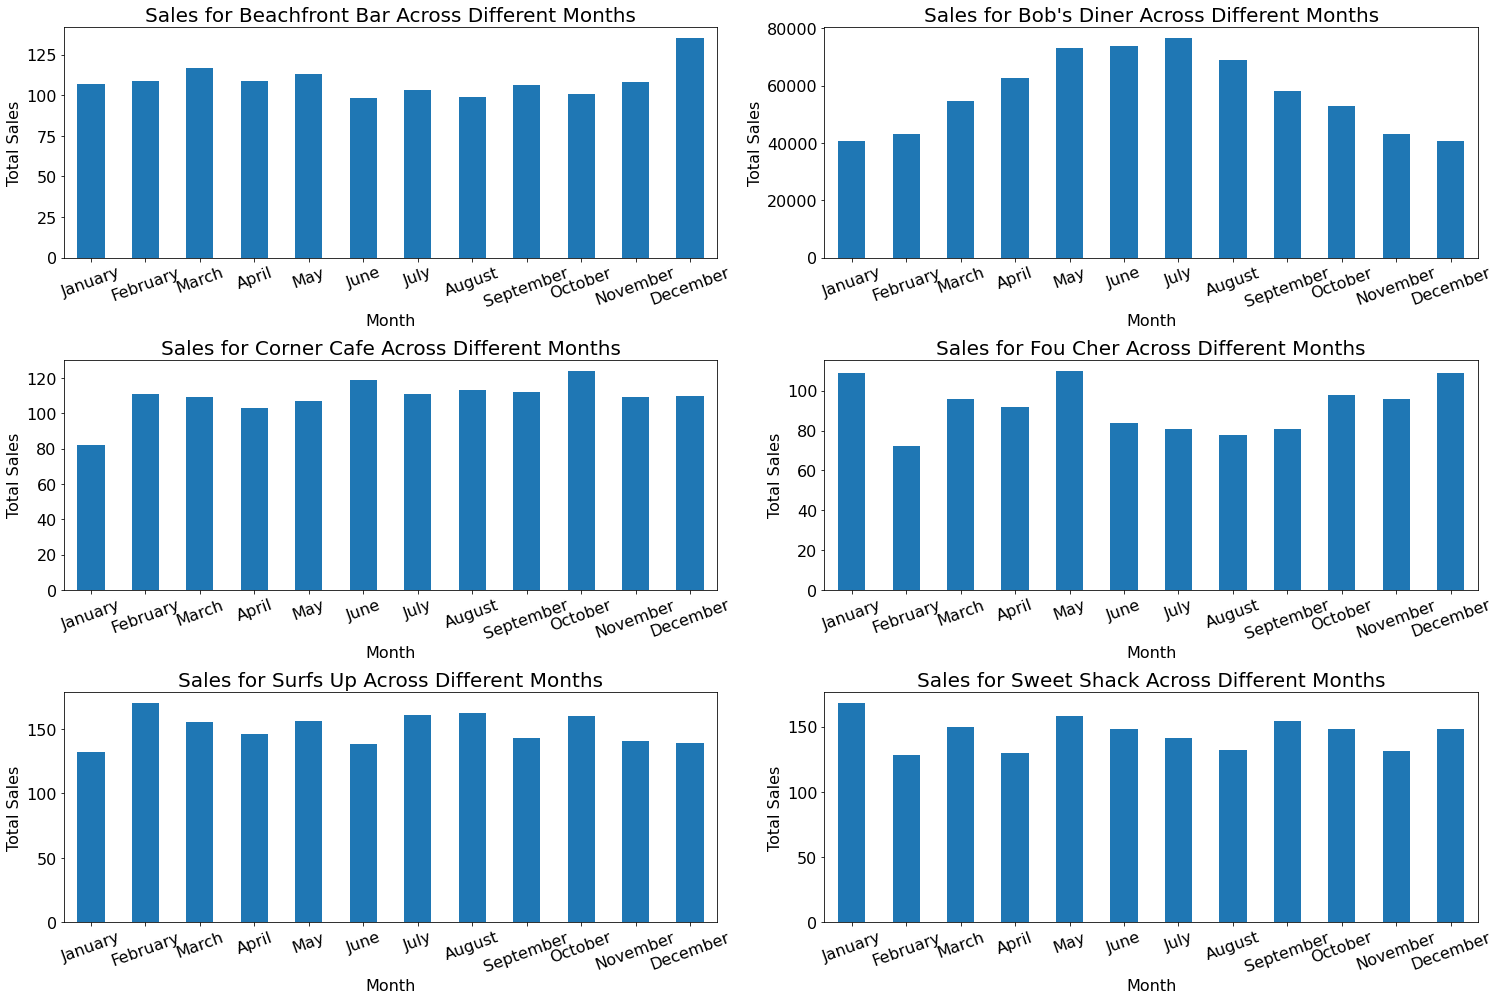

In [135]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(21, 14))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each restaurant's sales in a subplot
for i, restaurant in enumerate(restaurant_sales_by_month.index):
    restaurant_sales_by_month.loc[[restaurant]].T.plot(
        kind='bar', ax=axes[i], legend=False
    )
    axes[i].set_title(f'Sales for {restaurant} Across Different Months', fontsize = 20)
    axes[i].set_xlabel('Month', fontsize = 16)
    axes[i].set_ylabel('Total Sales', fontsize = 16)
    axes[i].tick_params(axis='x', labelsize = 16, rotation=20)
    axes[i].tick_params(axis='y', labelsize = 16, rotation=0)  # Keep x-ticks readable
    

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [137]:
# Group by store name and day of the week, summing the item counts
restaurant_day_sales = eda_dataset.groupby(['store_name', 'day_of_week'])['item_count'].sum()

# Unstack the store names to create a table-like structure for plotting
restaurant_day_sales = restaurant_day_sales.unstack()

# Reorder the columns (days of the week) for better readability
restaurant_day_sales = restaurant_day_sales[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]

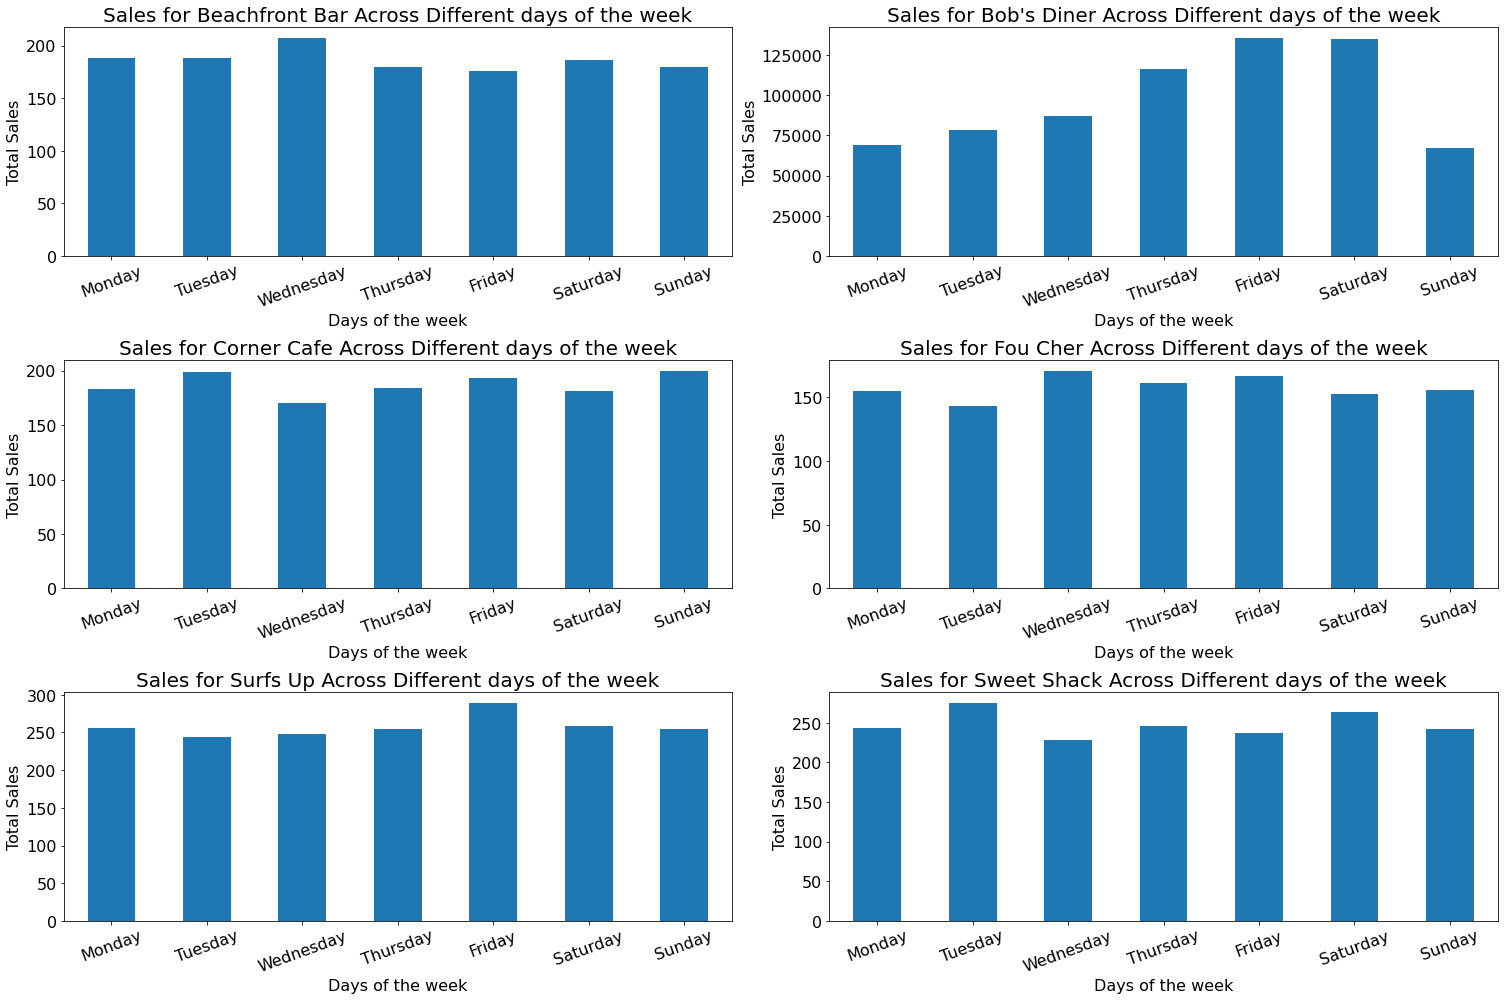

In [139]:
# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(21, 14))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Plot each restaurant's sales in a subplot
for i, restaurant in enumerate(restaurant_day_sales.index):
    restaurant_day_sales.loc[[restaurant]].T.plot(
        kind='bar', ax=axes[i], legend=False
    )
    axes[i].set_title(f'Sales for {restaurant} Across Different days of the week', fontsize = 20)
    axes[i].set_xlabel('Days of the week', fontsize = 16)
    axes[i].set_ylabel('Total Sales', fontsize = 16)
    axes[i].tick_params(axis='x', labelsize = 16, rotation=20)
    axes[i].tick_params(axis='y', labelsize = 16, rotation=0)  # Keep x-ticks readable
    

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [140]:
# Find out which restaurant had the most sales and look at the sales for each restaurant across different years, months, and days.
# Calculate total sales for each restaurant
restaurant_sales = eda_dataset.groupby('store_name')['item_count'].sum().sort_values(ascending=False)

# Identify the restaurant with the most sales
most_sales_restaurant = restaurant_sales.index[0]

print("Restaurant with the Most Sales:", most_sales_restaurant)
print("\nTotal Sales by Restaurant:\n", restaurant_sales)

Restaurant with the Most Sales: Bob's Diner

Total Sales by Restaurant:
 store_name
Bob's Diner       687527
Surfs Up            1803
Sweet Shack         1736
Corner Cafe         1310
Beachfront Bar      1305
Fou Cher            1106
Name: item_count, dtype: int64


f.
Identify the most popular items overall and the stores where they are being sold. Also, find
out the most popular item at each store

In [149]:
# Most popular items overall
overall_popular_items = eda_dataset.groupby('item_name')['item_count'].sum().sort_values(ascending=False).head(20)
print("20 Most Popular Items Overall:\n", overall_popular_items)

20 Most Popular Items Overall:
 item_name
Strawberry Smoothy                     236337
Frozen Milky Smoothy                   103263
Amazing pork lunch                      61043
Mutton Dinner                           52772
Orange Juice                            43874
Blue Ribbon Beef Entree                 42774
Amazing Steak Dinner with Rolls         34439
Sweet Frozen Soft Drink                 27490
Sea Bass with Vegetables Dinner         23839
Sweet Lamb Cake                         18764
Amazing Fish with Vegetables Meal       13190
Fantastic Sweet Cola                     7791
Awesome Sweet Lamb Cake                  6674
Milky Cake                               4062
Sweet Fruity Cake                        2946
Awesome Fish with Vegetables Entree      2944
Awesome Smoothy                          1692
Sweet Breaded Zucchini Cake              1515
Fantastic Frozen Milky Cake              1294
Fantastic Milky Smoothy                  1165
Name: item_count, dtype: int64


In [147]:
# Stores where the most popular items are being sold
most_popular_items = overall_popular_items
for item_name in most_popular_items.index:
    stores = eda_dataset[eda_dataset['item_name'] == item_name]['store_name'].unique()
    print(f"\n{item_name} is being sold at stores: {', '.join(map(str, stores))}")



Strawberry Smoothy is being sold at stores: Bob's Diner

Frozen Milky Smoothy is being sold at stores: Bob's Diner, Corner Cafe

Amazing pork lunch is being sold at stores: Bob's Diner

Mutton Dinner is being sold at stores: Bob's Diner

Orange Juice is being sold at stores: Bob's Diner

Blue Ribbon Beef Entree is being sold at stores: Bob's Diner

Amazing Steak Dinner with Rolls is being sold at stores: Bob's Diner

Sweet Frozen Soft Drink is being sold at stores: Bob's Diner

Sea Bass with Vegetables Dinner is being sold at stores: Bob's Diner

Sweet Lamb Cake is being sold at stores: Bob's Diner

Amazing Fish with Vegetables Meal is being sold at stores: Bob's Diner

Fantastic Sweet Cola is being sold at stores: Bob's Diner

Awesome Sweet Lamb Cake is being sold at stores: Bob's Diner

Milky Cake is being sold at stores: Bob's Diner, Fou Cher, Corner Cafe

Sweet Fruity Cake is being sold at stores: Bob's Diner

Awesome Fish with Vegetables Entree is being sold at stores: Bob's Dine

In [148]:
# Most popular item at each store
most_popular_item_per_store = eda_dataset.groupby(['store_name', 'item_name'])['item_count'].sum().reset_index()
most_popular_item_per_store = most_popular_item_per_store.loc[most_popular_item_per_store.groupby('store_name')['item_count'].idxmax()]
print("\nMost popular item at each store:\n", most_popular_item_per_store[['store_name', 'item_name', 'item_count']])


Most popular item at each store:
         store_name                      item_name  item_count
1   Beachfront Bar        Fantastic Milky Smoothy        1147
25     Bob's Diner             Strawberry Smoothy      236337
40     Corner Cafe           Frozen Milky Smoothy         273
57        Fou Cher  Blue Ribbon Fruity Vegi Lunch         298
85        Surfs Up             Awesome Soft Drink         997
92     Sweet Shack                Awesome Smoothy        1692


g. Determine if the store with the highest sales volume is also making the most money per day

In [153]:
# Calculate total sales volume (item count) for each store
store_sales_volume = eda_dataset.groupby('store_name')['item_count'].sum().sort_values(ascending=False)
highest_sales_volume_store = store_sales_volume.index[0]
highest_sales_volume = store_sales_volume.iloc[0]

# Calculate total revenue for each store
eda_dataset['revenue'] = eda_dataset['price'] * eda_dataset['item_count']  # Create a new column for revenue
store_revenue = eda_dataset.groupby('store_name')['revenue'].sum().sort_values(ascending=False)
highest_revenue_store = store_revenue.index[0]
highest_revenue = store_revenue.iloc[0]

# Output results
print(f"Store with Highest Sales Volume: {highest_sales_volume_store} ({highest_sales_volume} items sold)")
print(f"Store with Highest Revenue: {highest_revenue_store} (${highest_revenue:.2f})")

# Determine if they are the same
if highest_sales_volume_store == highest_revenue_store:
    print("The store with the highest sales volume is also making the most money per day.")
else:
    print("The store with the highest sales volume is NOT making the most money per day.")


Store with Highest Sales Volume: Bob's Diner (687527 items sold)
Store with Highest Revenue: Bob's Diner ($512483032.27)
The store with the highest sales volume is also making the most money per day.


h. Identify the most expensive item at each restaurant and find out its calorie count

In [158]:
# Find the index of the maximum price for each restaurant
max_price_indices = eda_dataset.groupby('store_name')['price'].idxmax()
# Select the rows corresponding to those indices
most_expensive_items = eda_dataset.loc[max_price_indices, ['store_name', 'item_name', 'price', 'kcal']]

In [159]:
most_expensive_items

,store_name,item_name,price,kcal
101712,Beachfront Bar,Fantastic Milky Smoothy,14.55,318
92111,Bob's Diner,Mutton Dinner,2224.80,542
30915,Corner Cafe,Awesome Hamburger with Fries,78.12,673
115,Fou Cher,Blue Ribbon Fruity Vegi Lunch,107.96,881
11909,Surfs Up,Steak Meal,52.42,607
25012,Sweet Shack,Awesome Smoothy,8.34,78


## Forecasting using machine learning algorithms:

In [327]:
# Data Preprocessing and Feature Engineering
# Convert 'date' to datetime objects
sales['date'] = pd.to_datetime(sales['date'], format='%d-%m-%Y')

# Merge sales data with item data
sales_data = pd.merge(sales, items, left_on='item_id', right_on='id', suffixes=('_sales', '_items'))

# Aggregate sales by date
daily_sales = sales_data.groupby('date')['item_count'].sum().reset_index()
daily_sales = daily_sales.sort_values(by='date')

# Feature Engineering
def create_features(df):
    """
    Function to create time-based features from the date column.
    """
    
    df['year'] = df['date'].dt.year
    df['month'] = df['date'].dt.month
    df['day'] = df['date'].dt.day
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['dayofyear'] = df['date'].dt.dayofyear
    df['weekofyear'] = df['date'].dt.isocalendar().week.astype(int)
    df['is_weekend'] = df['dayofweek'].apply(lambda x: 1 if x >= 5 else 0)
    return df

daily_sales = create_features(daily_sales) # Creating the features

In [328]:
# Define features (X) and target (y)
features = ['year', 'month', 'day', 'dayofweek', 'quarter', 'dayofyear', 'weekofyear', 'is_weekend']
target = 'item_count'

X = daily_sales[features]
y = daily_sales[target]

# Split data into training and testing sets (last six months for testing)
test_start_date = daily_sales['date'].max() - pd.DateOffset(months=6)
# Defining the start date for the test set
X_train = X[daily_sales['date'] <= test_start_date]
X_test = X[daily_sales['date'] > test_start_date]
y_train = y[daily_sales['date'] <= test_start_date]
y_test = y[daily_sales['date'] > test_start_date]

In [329]:
# Model Training and Evaluation
# Linear Regression
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
lr_predictions = lr_model.predict(X_test)
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_predictions))

print(f'Linear Regression RMSE: {lr_rmse}')

# Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_predictions = rf_model.predict(X_test)
rf_rmse = np.sqrt(mean_squared_error(y_test, rf_predictions))

print(f'Random Forest RMSE: {rf_rmse}')

# XGBoost
xgboost_model = xgb.XGBRegressor(n_estimators=100, random_state=42)
xgboost_model.fit(X_train, y_train)
xgboost_predictions = xgboost_model.predict(X_test)
xgboost_rmse = np.sqrt(mean_squared_error(y_test, xgboost_predictions))

print(f'XGBoost RMSE: {xgboost_rmse}')

Linear Regression RMSE: 230.69464124414785
Random Forest RMSE: 60.6606498857803
XGBoost RMSE: 65.0556107754231


In [330]:
# Model Comparison
models = {
    'Linear Regression': lr_rmse,
    'Random Forest': rf_rmse,
    'XGBoost': xgboost_rmse
}

best_model_name = min(models, key=models.get)
best_model = None

if best_model_name == 'Linear Regression':
    best_model = lr_model
elif best_model_name == 'Random Forest':
    best_model = rf_model
else:
    best_model = xgboost_model

print(f'The best performing model is: {best_model_name} with RMSE: {models[best_model_name]}')

The best performing model is: Random Forest with RMSE: 60.6606498857803


In [333]:
# Forecasting for the next year using the best model
# Create future dates for the next year
last_date = daily_sales['date'].max() # Getting the last date in the dataset
future_dates = [last_date + timedelta(days=i) for i in range(1, 366)] # Creating future dates for the next year
future_df = pd.DataFrame({'date': future_dates}) # Creating a DataFrame for future dates
future_df = create_features(future_df) # Creating features for future dates

# Extract features for future predictions
X_future = future_df[features]

# Make predictions
future_predictions = best_model.predict(X_future)

# Ensure predictions are non-negative
future_predictions[future_predictions < 0] = 0

# Create a DataFrame for the forecast
forecast = pd.DataFrame({'date': future_df['date'], 'predicted_sales': future_predictions})

print("\nForecast for the Next Year:")
forecast


Forecast for the Next Year:


,date,predicted_sales
0,2022-01-01,721.31
1,2022-01-02,283.15
2,2022-01-03,266.18
3,2022-01-04,345.47
4,2022-01-05,339.08
...,...,...
360,2022-12-27,304.79
361,2022-12-28,419.35
362,2022-12-29,568.40
363,2022-12-30,724.42


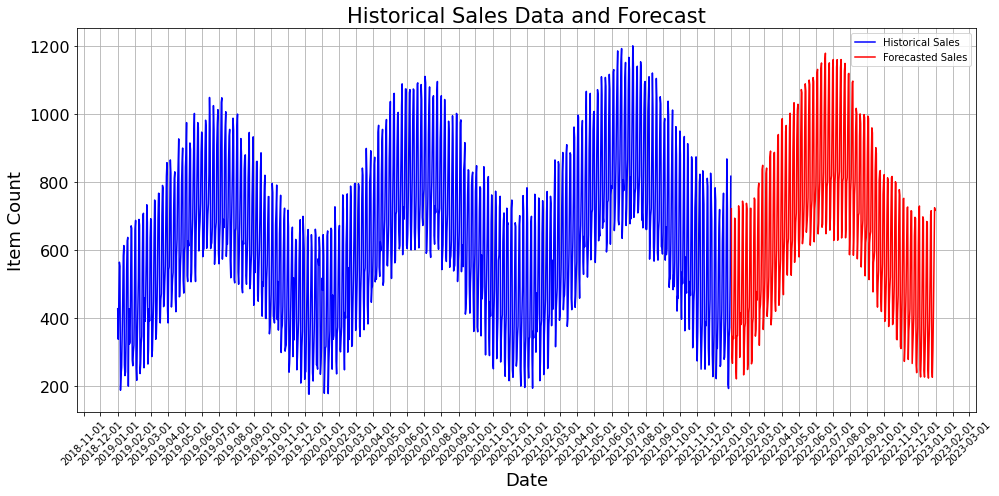

In [334]:
# Plotting the forecast along with historical data
plt.figure(figsize=(14, 7))

# Plot historical data
plt.plot(daily_sales['date'], daily_sales['item_count'], label='Historical Sales', color='blue')

# Plot forecast data
plt.plot(forecast['date'], forecast['predicted_sales'], label='Forecasted Sales', color='red')

# Customize the plot
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Item Count', fontsize = 18)
plt.title('Historical Sales Data and Forecast', fontsize = 21)
plt.legend()
plt.grid(True)

# Format the date on the x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.xticks(rotation=45)
plt.yticks(fontsize = 16)

plt.tight_layout()
plt.show()

## Forecasting using deep learning algorithms:
a. Use sales amount for predictions instead of item count

In [303]:
# Create a copy of the DataFrame
dl_dataset = merged_data.copy()

# Convert 'date' column to datetime format in the dataset
dl_dataset['date'] = pd.to_datetime(dl_dataset['date'], format='%d-%m-%Y')

# Calculate total sales amount
dl_dataset['total_sales'] = dl_dataset['item_count'] * dl_dataset['price']

# Aggregate sales amount by date
daily_sales = dl_dataset.groupby('date')['total_sales'].sum().reset_index() # Get total profit
daily_sales = daily_sales.sort_values(by='date') # Make it time series data
daily_sales = daily_sales.set_index('date') # Set the date as the index

b. Build a long short-term memory (LSTM) model for predictions
- Define the train and test series
- Generate synthetic data for the last 12 months
- Build and train an LSTM model
- Use the model to make predictions for the test data

In [304]:
# Scale the data
scaler = MinMaxScaler()
scaled_sales = scaler.fit_transform(daily_sales)

# Define train and test series
test_size = 365  # 12 months
train_data = scaled_sales[:-test_size] # The data before the last year
test_data = scaled_sales[-test_size:] # The last year

# Function to create sequences - makes the problem a supervised learning problem
def create_sequences(data, seq_length):
    # This function converts a single list of data into sequences for LSTM input.
    X, y = [], [] # X is the input values and y is the values to predict
    for i in range(len(data) - seq_length - 1):
# Loop over data with window size.  Must subtract sequence length and 1 to create sequences
        seq = data[i:(i + seq_length)] # Takes data
        label = data[i + seq_length] # the value after sequence length
        X.append(seq) # Add sequence data to input values
        y.append(label) # Add label to output values
    return np.array(X), np.array(y) # Returns np arrays of sequences and labels

In [305]:
seq_length = 30  # Length of input sequences
X_train, y_train = create_sequences(train_data, seq_length) # Create inputs and labels for training
X_test, y_test = create_sequences(test_data, seq_length) # Create inputs and labels for testing

# Reshape input to be [samples, time steps, features] - Reshape data to 3d for LSTM
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1)) 
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

# Build LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(units=50))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

In [306]:
# Train the LSTM model
model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=0) # Reduce verbosity

In [307]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions) # Put data back on original scale
y_test = scaler.inverse_transform(y_test) # Put data back on original scale

11/11 [==============================] - 1s 7ms/step


c. Calculate the mean absolute percentage error (MAPE) and comment on the model's performance

In [320]:
# Calculate MAPE
mape = mean_absolute_percentage_error(y_test, predictions)
print(f'Mean Absolute Percentage Error (MAPE): {mape:.4f}')

Mean Absolute Percentage Error (MAPE): 0.1950


Your Mean Absolute Percentage Error (MAPE) of 0.1950 (or 19.50%) is a decent result. While a MAPE below 10% is considered highly accurate, a MAPE between 10-20% is acceptable for many forecasting applications.

d. Develop another model using the entire series for training, and use it to forecast for the next three
months

In [309]:
# Prepare data for full series training
full_data = scaled_sales # Take scaled data
X_full, y_full = create_sequences(full_data, seq_length) # Create sequences with scaled data
X_full = np.reshape(X_full, (X_full.shape[0], X_full.shape[1], 1)) # Reshape with correct dimensions

# Build and train the full model
full_model = Sequential()
full_model.add(LSTM(units=50, return_sequences=True, input_shape=(X_full.shape[1], 1)))
full_model.add(LSTM(units=50))
full_model.add(Dense(units=1))
full_model.compile(optimizer='adam', loss='mean_squared_error')
full_model.fit(X_full, y_full, epochs=50, batch_size=32, verbose=0) # Reduce verbosity

In [310]:
# Forecast for the next three months (90 days)
forecast_period = 90
forecast_input = full_data[-seq_length:] # Select the last sequence of data
forecast_list = [] # Create a data structure

for _ in range(forecast_period):
    # Reshape data for prediction
    x_input = forecast_input.reshape((1, seq_length, 1))
    # Make prediction
    yhat = full_model.predict(x_input, verbose=0) # Reduce verbosity
    # Add prediction to forecast list
    forecast_list.append(yhat[0,0])
    # Update forecast input to include prediction and exclude oldest value
    forecast_input = np.append(forecast_input[1:], yhat)

# Inverse transform the forecast
forecast = scaler.inverse_transform(np.array(forecast_list).reshape(-1, 1))

# Create a date range for the forecast period
last_date = daily_sales.index[-1]
forecast_dates = pd.date_range(last_date, periods=forecast_period + 1, freq='D')[1:]

# Create a DataFrame for the forecast
forecast_df = pd.DataFrame({'date': forecast_dates, 'forecast': forecast.flatten()})

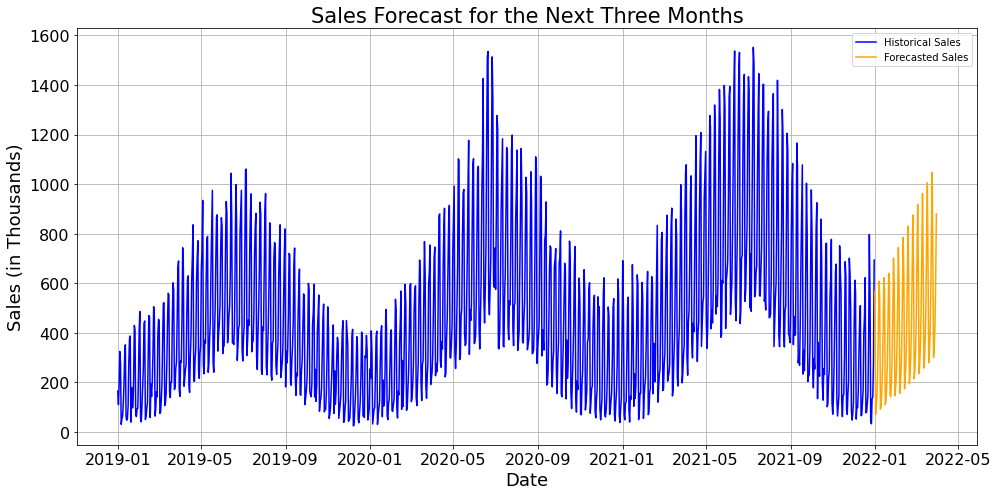

In [319]:
scaling_factor = 1000
# Plot the results
plt.figure(figsize=(14, 7))
plt.plot(daily_sales.index, daily_sales['total_sales']/scaling_factor, label='Historical Sales', color='blue')
plt.plot(forecast_df['date'], forecast_df['forecast']/scaling_factor, label='Forecasted Sales', color='orange')

plt.title('Sales Forecast for the Next Three Months', fontsize = 21)
plt.xlabel('Date', fontsize = 18)
plt.ylabel('Sales (in Thousands)', fontsize = 18)
plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


The model captures the seasonal trends well, and the forecasted sales (in orange) seem to follow the overall pattern of historical data.